In [2]:
import pandas as pd
from pathlib import Path

# Load your raw dataset
df = pd.read_csv("../data/raw/co2_emission_data.csv")

# --- Basic preprocessing ---
df_clean = df.dropna()  # removes missing values
df_clean.columns = df_clean.columns.str.strip().str.lower()  # cleans column names

# Ensure output directory exists, then save cleaned dataset
out_path = Path("../data/processed/cleaned_co2_data.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df_clean.to_csv(out_path, index=False)

print(f"✅ Cleaned data saved to {out_path}")
print(df_clean.head())


✅ Cleaned data saved to ..\data\processed\cleaned_co2_data.csv
        entity code  year  annual co₂ emissions (tonnes )
0  Afghanistan  AFG  1949                         14656.0
1  Afghanistan  AFG  1950                         84272.0
2  Afghanistan  AFG  1951                         91600.0
3  Afghanistan  AFG  1952                         91600.0
4  Afghanistan  AFG  1953                        106256.0


In [5]:
%pip install seaborn

# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Use the cleaned dataframe already loaded in the notebook
data = df_clean.copy()

# Step 3: View dataset info
print("Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nMissing values:\n", data.isnull().sum())
data.head()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Shape: (18646, 4)

Columns:
 Index(['entity', 'code', 'year', 'annual co₂ emissions (tonnes )'], dtype='object')

Missing values:
 entity                            0
code                              0
year                              0
annual co₂ emissions (tonnes )    0
dtype: int64


,entity,code,year,annual co₂ emissions (tonnes )
0,Afghanistan,AFG,1949,14656.0
1,Afghanistan,AFG,1950,84272.0
2,Afghanistan,AFG,1951,91600.0
3,Afghanistan,AFG,1952,91600.0
4,Afghanistan,AFG,1953,106256.0


In [6]:
# Summary statistics
data.describe()

# Check for duplicates
duplicates = data.duplicated().sum()
print("Duplicate rows:", duplicates)

# Data types
print("\nData types:\n", data.dtypes)


Duplicate rows: 0

Data types:
 entity                             object
code                               object
year                                int64
annual co₂ emissions (tonnes )    float64
dtype: object


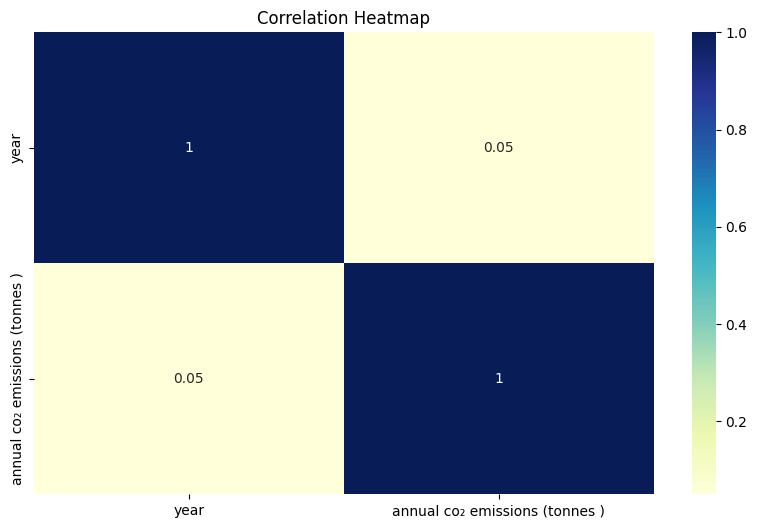

In [8]:
plt.figure(figsize=(10,6))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()


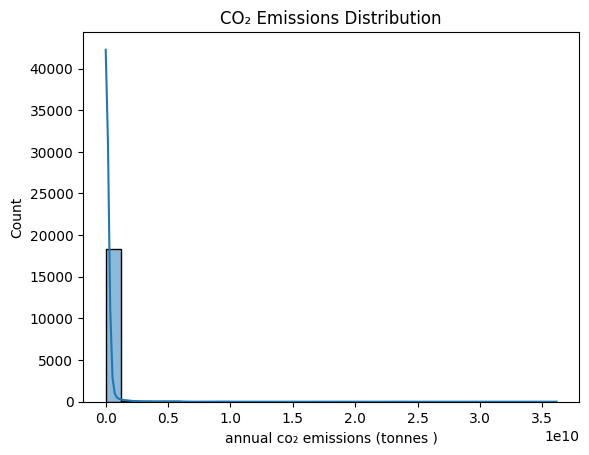

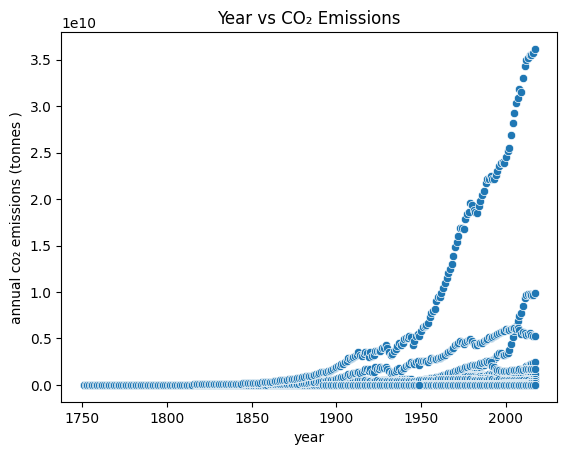

In [10]:
sns.histplot(data["annual co₂ emissions (tonnes )"], bins=30, kde=True)
plt.title("CO₂ Emissions Distribution")
plt.show()

# Scatterplot not possible as 'Energy_Consumption' and 'CO2_Emissions' columns do not exist
# If you want to plot emissions vs year:
sns.scatterplot(x="year", y="annual co₂ emissions (tonnes )", data=data)
plt.title("Year vs CO₂ Emissions")
plt.show()


In [12]:
# Example derived features (robust to different column names in the dataframe)
# Normalize column names to help finding the right columns (handles spaces/special chars)
def _normalize(name):
	return ''.join(ch if ch.isalnum() else '_' for ch in str(name).lower()).strip('_')

_norm_map = {_normalize(c): c for c in data.columns}

# Find likely CO2, energy, renewable and total-energy columns by keyword matching
co2_col = next((orig for norm, orig in _norm_map.items() if 'emiss' in norm or 'co2' in norm or 'co_2' in norm), None)
energy_col = next((orig for norm, orig in _norm_map.items() if 'energy' in norm), None)
renew_col = next((orig for norm, orig in _norm_map.items() if 'renew' in norm or 'renewable' in norm), None)
total_col = next((orig for norm, orig in _norm_map.items() if 'total' in norm or 'total_energy' in norm), None)

# Ensure CO2 column exists (dataset has 'annual co₂ emissions (tonnes )' in this notebook)
if co2_col is None:
	raise KeyError("No CO2/emissions column found in data. Available columns: " + ", ".join(data.columns))

# Compute Emission_Intensity if energy data exists, otherwise set NaN and warn
if energy_col is not None:
	data["Emission_Intensity"] = data[co2_col] / data[energy_col]
else:
	data["Emission_Intensity"] = np.nan
	print("Warning: Energy column not found. 'Emission_Intensity' set to NaN.")

# Compute Renewable_Share if renewable and total-energy columns exist, otherwise set NaN and warn
if renew_col is not None and total_col is not None:
	data["Renewable_Share"] = data[renew_col] / data[total_col]
else:
	data["Renewable_Share"] = np.nan
	print("Warning: Renewable or Total energy column not found. 'Renewable_Share' set to NaN.")

# Clean NaN and infinite values in the new features
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows where both new features are missing (keeps rows where at least one derived value is present)
data.dropna(how='all', subset=["Emission_Intensity", "Renewable_Share"], inplace=True)

data.head()


,entity,code,year,annual co₂ emissions (tonnes ),Emission_Intensity,Renewable_Share


In [13]:
data.to_csv("../data/processed/processed_co2_data.csv", index=False)
print("✅ Processed dataset saved successfully!")


✅ Processed dataset saved successfully!
